### Курсовая работа по Data Science

Импортируем библиотеки

In [3]:
import numpy as np
import pandas as pd

Пропишем путь к датасету

In [5]:
TRAIN_DATA_PATH = './real-estate-price-prediction-moscow/train.csv'

Откроем тренировочный датасет

In [30]:
df = pd.read_csv(TRAIN_DATA_PATH, sep=',')
df.head(4)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,11809,27,3.0,115.027311,NaN,10.0,4,10.0,2014,0.075424,B,B,11,3097,0,NaN,0,0,B,305018.871089
1,3013,22,1.0,39.832524,23.169223,8.0,7,8.0,1966,0.118537,B,B,30,6207,1,1183.0,1,0,B,177734.553407
2,8215,1,3.0,78.342215,47.671972,10.0,2,17.0,1988,0.025609,B,B,33,5261,0,240.0,3,1,B,282078.720850
3,2352,1,1.0,40.409907,NaN,1.0,10,22.0,1977,0.007122,B,B,1,264,0,NaN,0,1,B,168106.007630


Поделим данные на тренировучную и тестовую выборку

In [69]:
from sklearn.model_selection import train_test_split


X = df.drop("Price", axis=1) # Признаки
y = df["Price"] # Целевая переменная

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Добавим функцию обнаружения выбросов по алгоритму Z-Score

In [10]:
def zscore(column):
    outliers = []
    threshold = 3.5
    mean = column.mean()
    std = column.std()
    for cell in column:
        z_score = (cell - mean) / std
        if np.abs(z_score) > threshold:
            outliers.append(cell)
    return outliers

Добавим функцию конвертации категориальных переменных в дамми

In [15]:
def convert_to_dummies(df, col):
    if col not in df.columns:
        return df
    
    new_df = pd.concat([df, pd.get_dummies(df[col], prefix=col)], axis=1)
    new_df.drop(col, axis=1, inplace=True)
    return new_df

Проверим, какие признаки сильно коррелируются. Для линейной модели корреляция является проблемой

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(font_scale=1.4)

<AxesSubplot:>

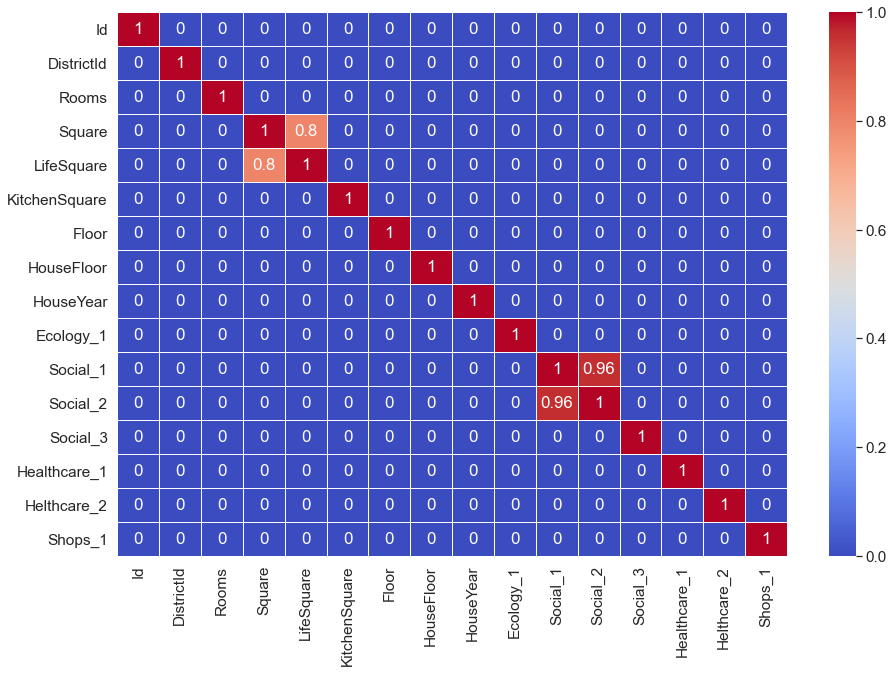

In [9]:
high_correlation_threshold = 0.75 # порог, после которого пара признаков считается сильно кореллирующей

corr_matrix = np.round(X_train.corr(), 2)
corr_matrix[np.abs(corr_matrix) < high_correlation_threshold] = 0

plt.figure(figsize = (15,10))
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')

Выведем пары сильно кореллирующих значений. Один признак из каждой пары удалим на этапе подготовки данных

In [16]:
for column in corr_matrix.columns:
    column_loc = corr_matrix.columns.get_loc(column)
    for row in range(len(corr_matrix.columns)):
        # После диагональной линии идет отзеркаленная часть,
        # не будем её рассматривать
        if column_loc == row:
            break
        if corr_matrix.iloc[row, column_loc] != 0:
            print(f"{column} {corr_matrix.columns[row]}")

LifeSquare Square
Social_2 Social_1


Подготовим данные

In [70]:
class DataPipeline:
    """Подготовка исходных данных"""
    
    def __init__(self):
        """Параметры класса"""
        
        # Медиана, а не среднее арифметическое, потому что медиана
        # не смещается из-за выбросов
        self.medians = None
        self.cols_with_missing = None
        
    def fit(self, df):
        """Сохранение статистик"""
        
        # Создадим список признаков на удаление
        
        self.cols_to_drop = [
            "Social_2"
        ]
        
        # Отметим столбцы с незаполненными ячейками
        
        self.cols_with_missing = [col for col in df.columns 
                                 if df[col].isnull().any()]
        
        # Скопируем нужные признаки из изначального состояния
        
        self.initial_cols = [col for col in df.columns
                             if df[col].dtype != 'object'
                             and col not in self.cols_to_drop]
        
        # Раcчитаем медианные значения
        
        self.medians = {}
        for col in self.initial_cols:
            self.medians[col] = df[col].median()
        
    def transform(self, df):
        """Трансформация данных"""
        
        # 1. Пропуски
        
        for col in self.cols_with_missing:
            df[col + '_was_missing'] = df[col].isnull()
            df[col].fillna(self.medians[col], inplace=True)
            
        # 2. Кореллирующие признаки
        
        df.drop(self.cols_to_drop, axis=1, inplace=True)
        
        # 3. Выбросы
        
        for col in self.initial_cols:
            df.loc[df[col].isin(zscore(df[col])), col] = self.medians[col]
        
        # 4. Новые признаки
        
        df = convert_to_dummies(df, "Ecology_2")
        df = convert_to_dummies(df, "Ecology_3")
        df = convert_to_dummies(df, "Shops_2")
        
        return df

In [71]:
pipe = DataPipeline()
pipe.fit(X_train)
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

<ipython-input-70-ad432efb8338>:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[col + '_was_missing'] = df[col].isnull()
c:\users\blaze\scoop\apps\python\3.9.1\lib\site-packages\pandas\core\series.py:4463: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().fillna(
c:\users\blaze\scoop\apps\python\3.9.1\lib\site-packages\pandas\core\frame.py:4308: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur

In [72]:
X_train

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,LifeSquare_was_missing,Healthcare_1_was_missing,Ecology_2_A,Ecology_2_B,Ecology_3_A,Ecology_3_B,Shops_2_A,Shops_2_B
9069,14858.0,31.0,1.0,38.234365,20.008121,8.0,6.0,3.0,1977.0,0.000000,...,0.0,4.0,False,True,0,1,0,1,0,1
2603,8231.0,11.0,1.0,31.309445,24.479166,5.0,1.0,5.0,1969.0,0.038693,...,2.0,5.0,False,False,0,1,0,1,0,1
7738,3799.0,123.0,2.0,47.234446,19.363580,6.0,2.0,12.0,1980.0,0.000000,...,3.0,5.0,False,False,0,1,0,1,0,1
1579,11635.0,61.0,3.0,63.841680,38.098612,8.0,9.0,12.0,1983.0,0.300323,...,1.0,9.0,False,True,0,1,0,1,0,1
5058,16592.0,27.0,1.0,36.054331,34.296082,1.0,15.0,17.0,2016.0,0.011654,...,0.0,0.0,False,True,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,6137.0,22.0,3.0,79.650439,32.616950,1.0,19.0,20.0,1977.0,0.118537,...,1.0,0.0,True,False,0,1,0,1,0,1
5191,4451.0,1.0,3.0,79.953687,32.616950,1.0,12.0,17.0,1977.0,0.007122,...,0.0,1.0,True,True,0,1,0,1,0,1
5390,13236.0,11.0,1.0,39.698660,25.570715,7.0,5.0,9.0,1982.0,0.038693,...,2.0,5.0,False,False,0,1,0,1,0,1
860,10404.0,6.0,1.0,43.613432,3.668460,1.0,3.0,17.0,2016.0,0.243205,...,0.0,0.0,False,False,0,1,0,1,0,1


Также посмотрим диаграмму другой пары кореллирующих признаков и на их примере решим моральный вопрос

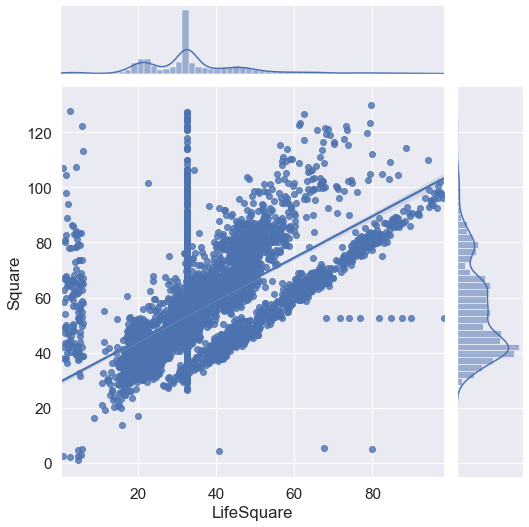

In [60]:
grid = sns.jointplot(x=X_train['LifeSquare'], y=X_train['Square'], kind='reg')
grid.fig.set_figwidth(8)
grid.fig.set_figheight(8)

plt.show()

Как мы видим на диаграмме, от общей картины ответвляются хвостики. Это заполненные, ранее пустые значения.
С одной стороны, хочется проецировать их на диагональную линию, которую обтекают основные данные, с другой стороны, от этого корелляция этих признаков только возрастет и хочется один из них удалить. Как поступить, это сложный морально-этический вопрос. Формально, корреляция этих двух признаков меньше порога сильной корелляции, значит их оба можно оставить

Создадим модель линейной регрессии с L2 регуляризацией (Ridge) и обучим её

In [73]:
from sklearn.linear_model import Ridge


model = Ridge(alpha=1)
model.fit(X_train, y_train)

Ridge(alpha=1)

Предскажем цены на недвижимость и оценим качество модели

In [74]:
from sklearn.metrics import r2_score


y_pred = model.predict(X_test)

print(f"R2 на обучаемой выборке: {r2_score(y_train, model.predict(X_train))}")
print(f"R2 на тестовой выборке: {r2_score(y_test, y_pred)}")

R2 на обучаемой выборке: 0.5610058098355825
R2 на тестовой выборке: 0.5771335048971684
